In [1]:
import pandas as pd
import random
from collections import Counter 
import operator
import math
import mmh3
import numpy as np


# Flow Data Discretization Task

This task is based on Dataset 51 and for infected host, 147.32.84.165 was chosen.

In [301]:
import numpy
import matplotlib.pyplot as plt

data_file = 'capture20110818.pcap.netflow.labeled' #dataset 51
infected_host = '147.32.84.165'
columns=['Date','Duration','Protocol','SrcIP', 'srcPort','DstIP', 'DstPort', 'Flags', 'TOS', 'Packets', 'Bytes', 'Label']
infected_lst= list()
uninfected_lst = list()
with open(data_file) as fp:
    for cnt, line in enumerate(fp):
        if cnt!=0:
            index = 0
            data = line.split("\t")
            data = list(filter(None, data)) 
            date = data[index]
            try:
                duration = data[index + 1]
            except:
                data = line.split(" ")
                data = list(filter(None, data)) 
                date = data[0] + " " + data[1]
                index = 1
                duration = data[index + 1]
            protocol = data[index + 2]
            src = data[index + 3].split(':')
            if len(src) < 2: # Set port to 0 if no port provided
                src.append(0)
            dst = data[index + 5].split(':')
            if len(dst) < 2:
                dst.append(0)
            flags = data[index + 6]
            tos = data[index + 7]
            packets = int(data[index + 8])
            byteno = float(data[index + 9])
            flows = data[index + 10]
            label = data[index + 11].rstrip()
            if label == 'Background':
                continue
            if (src[0] == dst[0]):
                print("CONNECT TO SELF")
            if (src[0] != infected_host and dst[0] != infected_host):
                uninfected_lst.append([date, duration, protocol, src[0], src[1], dst[0], dst[1], flags, tos, packets, byteno, label])
            else:
                infected_lst.append([date, duration, protocol, src[0], src[1], dst[0], dst[1], flags, tos, packets, byteno, label])
# add information associated with infected host to infected_df            
infected_df = pd.DataFrame(infected_lst, columns=columns)
# add information not associated with infected host to uninfected_df            
uninfected_df = pd.DataFrame(uninfected_lst, columns=columns)

In [377]:
# Print mean and standard deviation of all numerical columns to see if there are interesting differences
# Convert Protocol to dummies to also get stats on protocol
infected_dummy_df = pd.concat([infected_df, pd.get_dummies(infected_df.Protocol)], axis=1)
uninfected_dummy_df = pd.concat([uninfected_df, pd.get_dummies(uninfected_df.Protocol)], axis=1)
print('infected mean:')
print(infected_dummy_df.groupby(['Label']).mean())
print('\n uninfected mean:')
print(uninfected_dummy_df.groupby(['Label']).mean())
print('\n infected std:')
print(infected_dummy_df.groupby(['Label']).std())
print('\n uninfected std:')
print(uninfected_dummy_df.groupby(['Label']).std())

infected mean:
          Packets       Bytes      ICMP       TCP       UDP
Label                                                      
Botnet  12.038034  10938.6793  0.959934  0.027874  0.012193

 uninfected mean:
              Packets         Bytes      ICMP       TCP       UDP
Label                                                            
Botnet      11.275546  10308.424987  0.966215  0.022952  0.010833
LEGITIMATE  23.687808  16593.959900  0.003150  0.966895  0.029955

 infected std:
          Packets         Bytes      ICMP       TCP       UDP
Label                                                        
Botnet  84.293063  69710.054287  0.196118  0.164614  0.109747

 uninfected std:
               Packets          Bytes      ICMP       TCP       UDP
Label                                                              
Botnet       80.262679   66423.425153  0.180676  0.149751  0.103517
LEGITIMATE  154.185725  177137.115201  0.056035  0.178911  0.170463


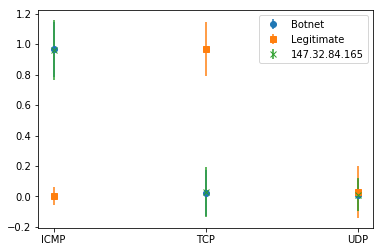

In [378]:
# Plot mean and standard deviation of 'ICMP','TCP', 'UDP' grouped on Label
error_df = uninfected_dummy_df[['ICMP','TCP', 'UDP', 'Label']]
x_values = list(error_df.groupby(['Label']).mean())
y_values = error_df.groupby(['Label']).mean().values
errors = error_df.groupby(['Label']).std().values

x = x_values
y = y_values[0]
e = errors[0]
plt.errorbar(x, y, e, linestyle='None', marker='o', label='Botnet')

x = x_values
y = y_values[1]
e = errors[1]
plt.errorbar(x, y, e, linestyle='None', marker='s', label='Legitimate')

error_df = infected_dummy_df[['ICMP','TCP', 'UDP', 'Label']]
x = list(error_df.groupby(['Label']).mean())
y = error_df.groupby(['Label']).mean().values[0]
e = error_df.groupby(['Label']).std().values[0]
plt.errorbar(x, y, e, linestyle='None', marker='x', label='147.32.84.165')

plt.legend()
plt.show()

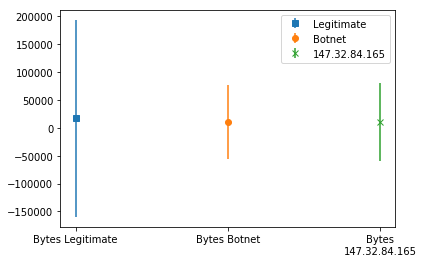

In [379]:
# Plot mean and standard deviation of Bytes grouped on Label
error_df = uninfected_dummy_df[['Bytes', 'Label']]
y_values = error_df.groupby(['Label']).mean().values
errors = error_df.groupby(['Label']).std().values

x = ['Bytes Legitimate']
y = y_values[1]
e = errors[1]
plt.errorbar(x, y, e, linestyle='None', marker='s', label='Legitimate')

x = ['Bytes Botnet']
y = y_values[0]
e = errors[0]
plt.errorbar(x, y, e, linestyle='None', marker='o', label='Botnet')

error_df = infected_dummy_df[['Bytes', 'Label']]
x = ['Bytes\n147.32.84.165']
y = error_df.groupby(['Label']).mean().values[0]
e = error_df.groupby(['Label']).std().values[0]
plt.errorbar(x, y, e, linestyle='None', marker='x', label='147.32.84.165')

plt.legend()
plt.show()

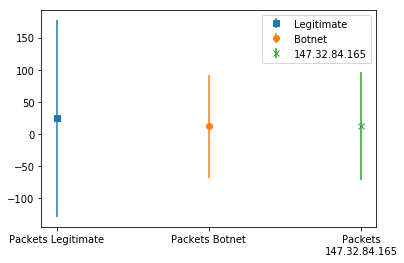

In [380]:
# Plot mean and standard deviation of Packets grouped on label
error_df = uninfected_dummy_df[['Packets', 'Label']]
y_values = error_df.groupby(['Label']).mean().values
errors = error_df.groupby(['Label']).std().values

x = ['Packets Legitimate']
y = y_values[1]
e = errors[1]
plt.errorbar(x, y, e, linestyle='None', marker='s', label='Legitimate')

x = ['Packets Botnet']
y = y_values[0]
e = errors[0]
plt.errorbar(x, y, e, linestyle='None', marker='o', label='Botnet')

error_df = infected_dummy_df[['Packets', 'Label']]
x = ['Packets\n147.32.84.165']
y = error_df.groupby(['Label']).mean().values[0]
e = error_df.groupby(['Label']).std().values[0]
plt.errorbar(x, y, e, linestyle='None', marker='x', label='147.32.84.165')

plt.legend()
plt.show()

# Explore the Flags attribute to see if it is useful for discretization

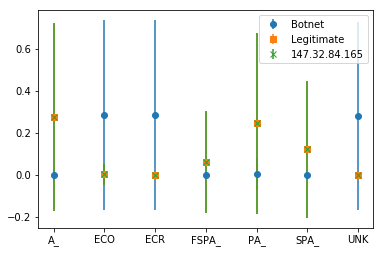

In [382]:
import matplotlib.pyplot as plt
import numpy as np

# Explore if the Flags attribute is useful
# Split flag attribute into dummies
uninf_flags_df = pd.concat([uninfected_df[['Label']], pd.get_dummies(uninfected_df.Flags)], axis=1)
inf_flags_df = pd.concat([infected_df[['Label']], pd.get_dummies(infected_df.Flags)], axis=1)

# Group dataframes based on the labels
uninf_flags_labelsGroup = uninf_flags_df.groupby(['Label'])
inf_flags_labelsGroup = inf_flags_df.groupby(['Label'])

mean_df1 = inf_flags_labelsGroup.mean()
mean_df2 = uninf_flags_labelsGroup.mean()
std_df1 = inf_flags_labelsGroup.std()
std_df2 = uninf_flags_labelsGroup.std()
columns_total = mean_df1.columns
columns_total.append(mean_df2.columns)

# Find all flag columns where one of the means is higher than threshold (0.05)
threshold = 0.05
flag_dict = dict()
for col in columns_total:
    inf_val, bot_uninf, leg_uninf = 0,0,0
    if col in mean_df1.columns:
        inf_val = mean_df1[col][0]
    if col in mean_df2.columns:
        bot_uninf = mean_df2[col][0]
        leg_uninf = mean_df2[col][1]
    if inf_val >= threshold or bot_uninf >= threshold or leg_uninf >= threshold:
        flag_dict[col] = [inf_val, bot_uninf, leg_uninf, std_df1[col][0], std_df2[col][0], std_df2[col][1]]
new_df = pd.DataFrame(flag_dict)
new_df.head(10)

# Using the found columns plot the mean and standard deviation
x = new_df.columns
y_values = mean_df2[x].values
errors = std_df2[x].values

y = y_values[0]
e = errors[0]
plt.errorbar(x, y, e, linestyle='None', marker='o', label='Botnet')

y = y_values[1]
e = errors[1]
plt.errorbar(x, y, e, linestyle='None', marker='s', label='Legitimate')

y_values = mean_df1[x].values
errors = std_df1[x].values
plt.errorbar(x, y, e, linestyle='None', marker='x', label='147.32.84.165')

plt.legend()
plt.show()

Test out the protocol plus flag attribute on the infected host

In [383]:
# Combine Protocol and Flag for extra attribute
infected_df['ProtFlag'] = infected_df['Protocol'] + "+" + infected_df['Flags']

# Convert to numerical via dummies
uninf_protFlag_df = pd.concat([infected_df[['Label']], pd.get_dummies(infected_df.ProtFlag)], axis=1)

error_df = uninf_protFlag_df
error_mean = error_df.groupby(['Label']).mean()
error_mean.to_csv('test.csv')
error_mean.head()

# Only show means larger than or equal to threshold (0.05)
threshold = 0.05
for col in error_mean.columns:
    val = error_mean[col]
    if val[0] < threshold:
        error_mean.drop([col], axis=1, inplace=True)

# Round all values to 2 decimals
error_mean.round(2)

,ICMP+ECO,ICMP+ECR,ICMP+UNK
Label,,,
Botnet,0.28,0.29,0.27


Convert the not infected host dataset to see if the same values are achieved (yes, all hosts show that the values found for the infected host are also good predictors for other infected hosts)

            ICMP+ECO  ICMP+ECR  ICMP+UNK  TCP+A_  TCP+FA_  TCP+FSPA_  TCP+PA_  \
Label                                                                           
Botnet          0.29      0.29      0.28    0.00     0.00       0.00     0.01   
LEGITIMATE      0.00      0.00      0.00    0.28     0.09       0.06     0.25   

            TCP+SPA_  TCP+_FSPA  
Label                            
Botnet          0.00       0.00  
LEGITIMATE      0.12       0.06  


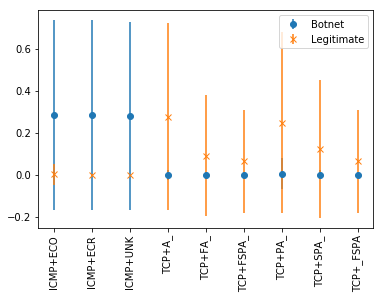

In [384]:
# Combine Protocol and Flag for extra attribute
uninfected_df['ProtFlag'] = uninfected_df['Protocol'] + "+" + uninfected_df['Flags']

# Convert to numerical via dummies
uninf_protFlag_df = pd.concat([uninfected_df[['Label']], pd.get_dummies(uninfected_df.ProtFlag)], axis=1)

uninf_protFlag_mean = uninf_protFlag_df.groupby(['Label']).mean()
uninf_protFlag_mean.to_csv('test.csv')
uninf_protFlag_mean.head()

# Only show means larger than or equal to threshold (0.05)
threshold = 0.05
for col in uninf_protFlag_mean.columns:
    val = uninf_protFlag_mean[col]
    if val[0] < threshold and val[1] < threshold:
        uninf_protFlag_mean.drop([col], axis=1, inplace=True)

# Round all values to 2 decimals
print(uninf_protFlag_mean.round(2))

# Continue with only the significant columns
leftover_columns = list(uninf_protFlag_mean.columns)
leftover_columns.append('Label')
uninf_protFlag_df = uninf_protFlag_df[leftover_columns]
uninf_protFlag_std = uninf_protFlag_df.groupby(['Label']).std()

x = uninf_protFlag_std.columns
y_values = uninf_protFlag_mean.values
errors = uninf_protFlag_std.values

y = y_values[0]
e = errors[0]
plt.errorbar(x, y, e, linestyle='None', marker='o', label='Botnet')
y = y_values[1]
e = errors[1]
plt.errorbar(x, y, e, linestyle='None', marker='x', label='Legitimate')
plt.xticks(rotation=90)

plt.legend()
plt.show()

In [385]:
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, OneD_SymbolicAggregateApproximation

# Discretize the Bytes attribute using PAA
dataset = uninfected_df.Bytes.apply(lambda x: float(x))
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset = scaler.fit_transform(dataset)

n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))
uninfected_df['paa_Bytes'] = paa_dataset_inv[0]


            ICMP+-0.018381672213281935  ICMP+-0.0333286367645249  \
Label                                                              
Botnet                            0.11                      0.14   
LEGITIMATE                        0.00                      0.00   

            ICMP+-0.048244770168523084  ICMP+-0.06627956795067147  \
Label                                                               
Botnet                            0.18                        0.2   
LEGITIMATE                        0.00                        0.0   

            ICMP+-0.06701576783867874  ICMP+-0.06849942976426047  \
Label                                                              
Botnet                           0.14                        0.2   
LEGITIMATE                       0.00                        0.0   

            TCP+-0.018381672213281935  TCP+-0.03331745552000447  \
Label                                                             
Botnet                           0.00      

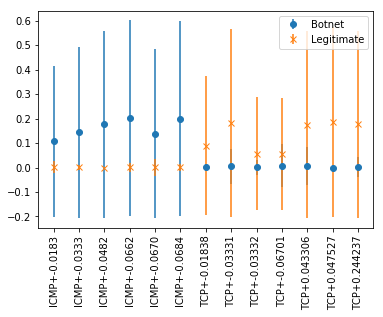

In [387]:
# Combine Protocol and Flag for extra attribute
uninfected_df['ProtBytes'] = uninfected_df['Protocol'] + "+" + uninfected_df['paa_Bytes'].map(str)

# Convert to numerical via dummies
uninf_protBytes_df = pd.concat([uninfected_df[['Label']], pd.get_dummies(uninfected_df.ProtBytes)], axis=1)

uninf_protBytes_mean = uninf_protBytes_df.groupby(['Label']).mean()
uninf_protBytes_mean.to_csv('test.csv')
uninf_protBytes_mean.head()

# Only show means larger than or equal to threshold (0.05)
threshold = 0.05
for col in uninf_protBytes_mean.columns:
    val = uninf_protBytes_mean[col]
    if val[0] < threshold and val[1] < threshold:
        uninf_protBytes_mean.drop([col], axis=1, inplace=True)

# Round all values to 2 decimals
print(uninf_protBytes_mean.round(2))
uninf_protBytes_mean.to_csv('test')

# Continue with only the significant columns
leftover_columns = list(uninf_protBytes_mean.columns)
leftover_columns.append('Label')
uninf_protBytes_df = uninf_protBytes_df[leftover_columns]
uninf_protBytes_std = uninf_protBytes_df.groupby(['Label']).std()

x = uninf_protBytes_std.columns
y_values = uninf_protBytes_mean.values
errors = uninf_protBytes_std.values

y = y_values[0]
e = errors[0]
plt.errorbar(x, y, e, linestyle='None', marker='o', label='Botnet')
y = y_values[1]
e = errors[1]
plt.errorbar(x, y, e, linestyle='None', marker='x', label='Legitimate')

# rotate x labels and shorten their text
plt.xticks(range(len(x)), [lab[:12] for lab in x],  rotation=90)
plt.legend()
plt.show()

# Botnet profiling task

Try to find a pattern of the infected host using markov chains

In [388]:
def create_prob_matrix(series, window_size = 1):
    """
    Create a probability matrix for a series with a defined window size
    """
    state_list = series
    window_list = create_window_list(state_list, window_size)

    # Map all states to an index for the matrix
    matrix_size = len(set(window_list))
    window_set = set(window_list)
    windows_set = list(window_set)
    window_to_index = {'start':0, 'end': matrix_size + 1}
    index_to_window = {0:'start', matrix_size + 1: 'end' }
    counter = 1
    for i in window_set:
        window_to_index[i] = counter
        index_to_window[counter] = i
        counter += 1
        
    # Create state transition matrix
    # matrix[state1][state2] = 1 means the transition from state 1 to state 2 was made 1 time
    matrix = numpy.zeros([matrix_size + 2, matrix_size + 2])
    prev = 0
    for window in window_list:
        nex = window_to_index[window]
        matrix[prev][nex] += 1
        prev = nex
    matrix[prev][matrix_size + 1] += 1

    # Create Probability matrix
    # matrix[state1][state2] = 0.5 means the transition from state 1 to state 2 is made with a 50% chance
    output_matrix = numpy.zeros([matrix_size + 2, matrix_size + 2])
    for row_n, row in enumerate(matrix):
        m_sum = row.sum()
        for col_n, val in enumerate(row):
            if val != 0:
                output_matrix[row_n][col_n] = val / m_sum
    return output_matrix, window_to_index, index_to_window

def create_window_list(state_list, window_size):
    """
    Function for getting a window of states from a list
    windows_size: the size of the windows returned
    """
    window_list = list()
    for i in range(window_size, len(state_list) - window_size):
        window = ''
        for window_index in range(window_size):
            window += state_list[i + window_index]
        window_list.append(window)
    return window_list

In [389]:
# Create the fingerprint (training matrix) from the infected host to match other hosts on
train_matrix, train_wti, train_itw = create_prob_matrix(infected_df.Protocol, window_size=1)

Using the Training Matrix/fingerprint match all other hosts and classify if it is infected or not

In [391]:
import time

In [370]:
infected_hosts = ['147.32.84.191', '147.32.84.192', '147.32.84.193', 
                  '147.32.84.204', '147.32.84.205', '147.32.84.206', 
                  '147.32.84.207', '147.32.84.208', '147.32.84.209']
all_hosts = uninfected_df.DstIP.unique()
similarity_dict = dict()
counter = 0
start = time.time()
for host in all_hosts:
    if counter % 200 == 0:
        print(f'Currently at: {counter}')
        print(f'time taken: {time.time() - start}')
    counter += 1
    test_host = uninfected_df[uninfected_df['DstIP'].str.contains(host) | uninfected_df['SrcIP'].str.contains(host)]
    test_host.reset_index(inplace=True)
    test_matrix, test_wti, test_itw = create_prob_matrix(test_host.Protocol, window_size=1)
    similarity = 0
    sim_thresh = 0
    for row_n, row in enumerate(test_matrix):
        for col_n, val in enumerate(row):
            from_window = test_itw[row_n]
            to_window = test_itw[col_n]

            # Check if probability matrices have similar values on the train marix values
            if from_window in train_wti.keys() and to_window in train_wti.keys():
                # convert windows to the train indices
                from_window = train_wti[from_window]
                to_window = train_wti[to_window]

                # Get the value for the from and to windows found in the test matrix
                train_val = train_matrix[from_window][to_window]

                if val <= train_val - sim_thresh or val >= train_val + sim_thresh:
                    continue
                else:
                    similarity += 1
    if host in infected_hosts:
        print(f'infected host: {host}, similarity: {similarity}')
    else:
        print(f'Normal host: {host}, similarity: {similarity}')
    similarity_dict[host] = similarity

print(f'Finished at: {time.time() - start}')

Currently at: 0
time taken: 0.001005411148071289
Normal host: 147.32.85.88, similarity: 0
0. 1. 0.
0.00000000e+00 9.99934392e-01 6.56081879e-05
0. 0. 0.
Finished at: 1.7537424564361572


In [392]:
# Find out the true/false positives/negatives
tp, tn, fp, fn = 0,0,0,0
highest_non_infected, lowest_infected, highest_infected = 0, 10000, 0
for key, value in similarity_dict.items():
    if value >= 10000:
        if key in infected_hosts:
            lowest_infected = min(lowest_infected, value)
            highest_infected = max(highest_infected, value)
            tp += 1
        else:
            highest_non_infected = max(highest_non_infected, value)
            fp += 1
    else:
        if key in infected_hosts:
            lowest_infected = min(lowest_infected, value)
            highest_infected = max(highest_infected, value)
            fn += 1
        else:
            highest_non_infected = max(highest_non_infected, value)
            tn += 1
print(tp, tn, fp, fn)
print(f'lowest infected: {lowest_infected}')
print(f'highest infected: {highest_infected}')
print(f'highest uninfected: {highest_non_infected}')


9
0 1 0 0
lowest infected: 10000
highest infected: 0
highest uninfected: 0
